In [104]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import pymc3 as pm
import bambi as bmb
import warnings
import arviz
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
#data = pd.read_csv('./shooter.csv', sep=',', na_values='.')
df = pd.read_csv('./shooter-data/shooter-group.csv', sep=',')
df.head()

,subject,age,stimulus,trial,race,gun,rt,correct,rate
0,18,27,b05,20,1,1,615,1,1.626016
1,18,27,b04,21,1,0,559,1,1.788909
2,18,27,w04,22,0,0,488,0,2.049180
3,18,27,b17,23,1,0,719,1,1.390821
4,18,27,w02,24,0,1,547,1,1.828154


In [106]:
gun_absent = df[ df['gun'] == 0 ].groupby('subject').mean()
gun_present = df[ df['gun'] == 1 ].groupby('subject').mean()
w_target = df[ df['race'] == 0 ].groupby('subject').mean()
b_target = df[ df['race'] == 1 ].groupby('subject').mean()

In [107]:
gun_absent.head()

,age,trial,race,gun,rt,correct,rate
subject,,,,,,,
1,35.0,66.591837,0.510204,0.0,665.571429,1.000000,1.528727
2,35.0,65.877551,0.489796,0.0,647.224490,1.000000,1.562691
3,34.0,69.061224,0.489796,0.0,624.081633,1.000000,1.618863
4,34.0,68.340000,0.500000,0.0,611.880000,1.000000,1.669828
5,33.0,69.000000,0.520833,0.0,622.708333,0.958333,1.640014


In [108]:
gun_present.drop(columns=['trial', 'race'], inplace=True)
gun_absent.drop(columns=['trial', 'race'], inplace=True)
w_target.drop(columns=['trial', 'gun'], inplace=True)
b_target.drop(columns=['trial', 'gun'], inplace=True)

In [109]:
gun_absent.head()

,age,gun,rt,correct,rate
subject,,,,,
1,35.0,0.0,665.571429,1.000000,1.528727
2,35.0,0.0,647.224490,1.000000,1.562691
3,34.0,0.0,624.081633,1.000000,1.618863
4,34.0,0.0,611.880000,1.000000,1.669828
5,33.0,0.0,622.708333,0.958333,1.640014


## scipy

In [110]:
t,p = scipy.stats.ttest_rel(gun_present['rt'], gun_absent['rt'])
print(t, p)

-15.907174725726094 1.3618862888819598e-17


In [111]:
# investigate the relationship between age and average reaction time
sub_means = df.groupby('subject').mean()
r,p = scipy.stats.pearsonr(sub_means['age'], sub_means['rt'])
print(r, p)

0.2526573392414475 0.13709806660421017


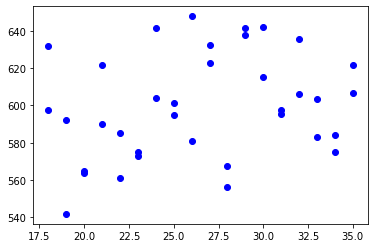

In [112]:
plt.plot(sub_means['age'], sub_means['rt'], 'bo')

In [113]:
r,p = scipy.stats.spearmanr(sub_means['age'], sub_means['rt'])
print(r, p)

0.26697608467831285 0.11547651011180153


## statsmodels

**Fully between-subject**

In [114]:
btw_aov_result = smf.ols('rt ~ race * gun', df).fit()
btw_aov_table = sm.stats.anova_lm(btw_aov_result, typ=2)
print(btw_aov_table)

                sum_sq      df           F        PR(>F)
race      6.154852e+03     1.0    0.800156  3.711083e-01
gun       3.259762e+06     1.0  423.782278  5.628394e-89
race:gun  2.788578e+05     1.0   36.252654  1.912428e-09
Residual  2.690685e+07  3498.0         NaN           NaN


**Within-subject, ANOVA-style**

In [115]:
wi_aov_model = statsmodels.stats.anova.AnovaRM(df, 'rt', 'subject', ['race', 'gun'], aggregate_func='mean')
wi_aov_result = wi_aov_model.fit()
print(wi_aov_result.summary())

                 Anova
         F Value  Num DF  Den DF Pr > F
---------------------------------------
race       1.0994 1.0000 35.0000 0.3016
gun      251.0629 1.0000 35.0000 0.0000
race:gun  60.1064 1.0000 35.0000 0.0000



In [116]:
# per-cell data
nogun_black = df[ (df['gun'] == 0) & (df['race'] == 0)].groupby('subject').mean()
nogun_white = df[ (df['gun'] == 0) & (df['race'] == 1)].groupby('subject').mean()
gun_white = df[ (df['gun'] == 1) & (df['race'] == 0)].groupby('subject').mean()
gun_black = df[ (df['gun'] == 1) & (df['race'] == 1)].groupby('subject').mean()

In [117]:
# example pair-wise comparison
t,p = scipy.stats.ttest_rel(nogun_black['rt'], gun_white['rt'])
print(t, p)

10.791593824133901 1.1128969055398514e-12


**Within subjects, Mixed model-style**

In [118]:
model = smf.mixedlm('rt ~ race * gun', data=df, groups=df['subject'])
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: rt         
No. Observations: 3502    Method:             REML       
No. Groups:       36      Scale:              6987.9281  
Min. group size:  94      Likelihood:         -20501.1152
Max. group size:  100     Converged:          Yes        
Mean group size:  97.3                                   
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  620.474    5.304 116.978 0.000 610.078 630.870
race        20.471    4.019   5.094 0.000  12.594  28.348
gun        -43.113    3.998 -10.783 0.000 -50.950 -35.277
race:gun   -35.829    5.651  -6.340 0.000 -46.905 -24.752
Group Var  723.610    2.286                              



## pymc3

In [119]:
# create a copy of the data for these analyses
pmdf = df.copy(deep=True)

# recode relevant variables so that they run 0..., in order
subject = pmdf.subject.astype('category').cat.codes
nSubjects = len(pmdf.subject.astype('category').cat.categories)

#id = pmdf.subject.unique()
#id_lookup = dict(zip(id, range(len(id))))
#subject = pmdf['subject'] = pmdf.subject.replace(id_lookup).values

gun = pmdf.gun.astype('category').cat.codes

#gun = pmdf.gun.unique()
#gun_lookup = dict(zip(gun, range(len(gun))))
#gun = pmdf['gun'] = pmdf.gun.replace(gun_lookup).values

race = pmdf.race.astype('category').cat.codes

#race_cond = pmdf.race.unique()
#race_lookup = dict(zip(race_cond, range(len(race_cond))))
#race = pmdf['race'] = pmdf.race.replace(race_lookup).values

In [120]:
# do a 'repeated measures ANOVA', treating subject as a random effect
with pm.Model() as my_model:
    zeroMean = 0
    sd = 1000
    b = 5

    # intercepts
    # we'll used the empirically observed mean as the location of this prior (typically we'd normalize our data)
    empiricalMean = pmdf['rt'].mean()
    alpha = pm.Normal('alpha', empiricalMean, sd=sd)
    alpha_SD = pm.HalfCauchy('alpha_SD', b)
    alpha_s = pm.Normal('alpha_s', alpha, sd=alpha_SD, shape=(nSubjects,))

    # coefficients for gun
    beta_gun = pm.Normal('beta_gun', zeroMean, sd=sd)
    beta_gun_beta = pm.HalfCauchy('beta_gun_beta', b)
    # here, we construct a non-centered specification of the per-subject coefficients
    # see Betancourt & Girolami (2015)
    beta_gun_s_offset = pm.Normal('beta_gun_s_offset', mu=zeroMean, sd=sd, shape=(nSubjects,))
    beta_gun_s = pm.Deterministic('beta_gun_s', beta_gun + beta_gun_s_offset * beta_gun_beta)
    # naive, centered specification
    #beta_gun_s = pm.Normal('beta_gun_s', beta_gun, sd=beta_gun_beta, shape=(nSubjects,))

    # coefficient for race
    beta_race = pm.Normal('beta_race', zeroMean, sd=sd)
    #beta_race_beta = pm.HalfCauchy('beta_race_beta', b)
    #beta_race_s = pm.Normal('beta_race_s', beta_race, sd=beta_race_beta, shape=nSubjects)

    # coefficient for interaction
    beta_gunrace = pm.Normal('beta_gunrace', zeroMean, sd=sd)
    #beta_gunrace_beta = pm.HalfCauchy('beta_gunrace_beta', b)
    #beta_gunrace_s = pm.Normal('beta_gunrace_s', beta_gunrace, sd=beta_gunrace_beta, shape=nSubjects)

    # Expected value
    y_hat = alpha_s[subject] + (beta_gun_s[subject] * gun) + (beta_race * race) + (beta_gunrace * gun * race)

    # Model error
    sigma_y = pm.HalfCauchy('sigma_y', b)

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=pmdf.rt.values)

/home/xian/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [121]:
with my_model:
    my_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, beta_gunrace, beta_race, beta_gun_s_offset, beta_gun_beta, beta_gun, alpha_s, alpha_SD, alpha]
INFO:pymc3:NUTS: [sigma_y, beta_gunrace, beta_race, beta_gun_s_offset, beta_gun_beta, beta_gun, alpha_s, alpha_SD, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [01:08<00:00, 44.03draws/s] 
/home/xian/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/home/xian/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


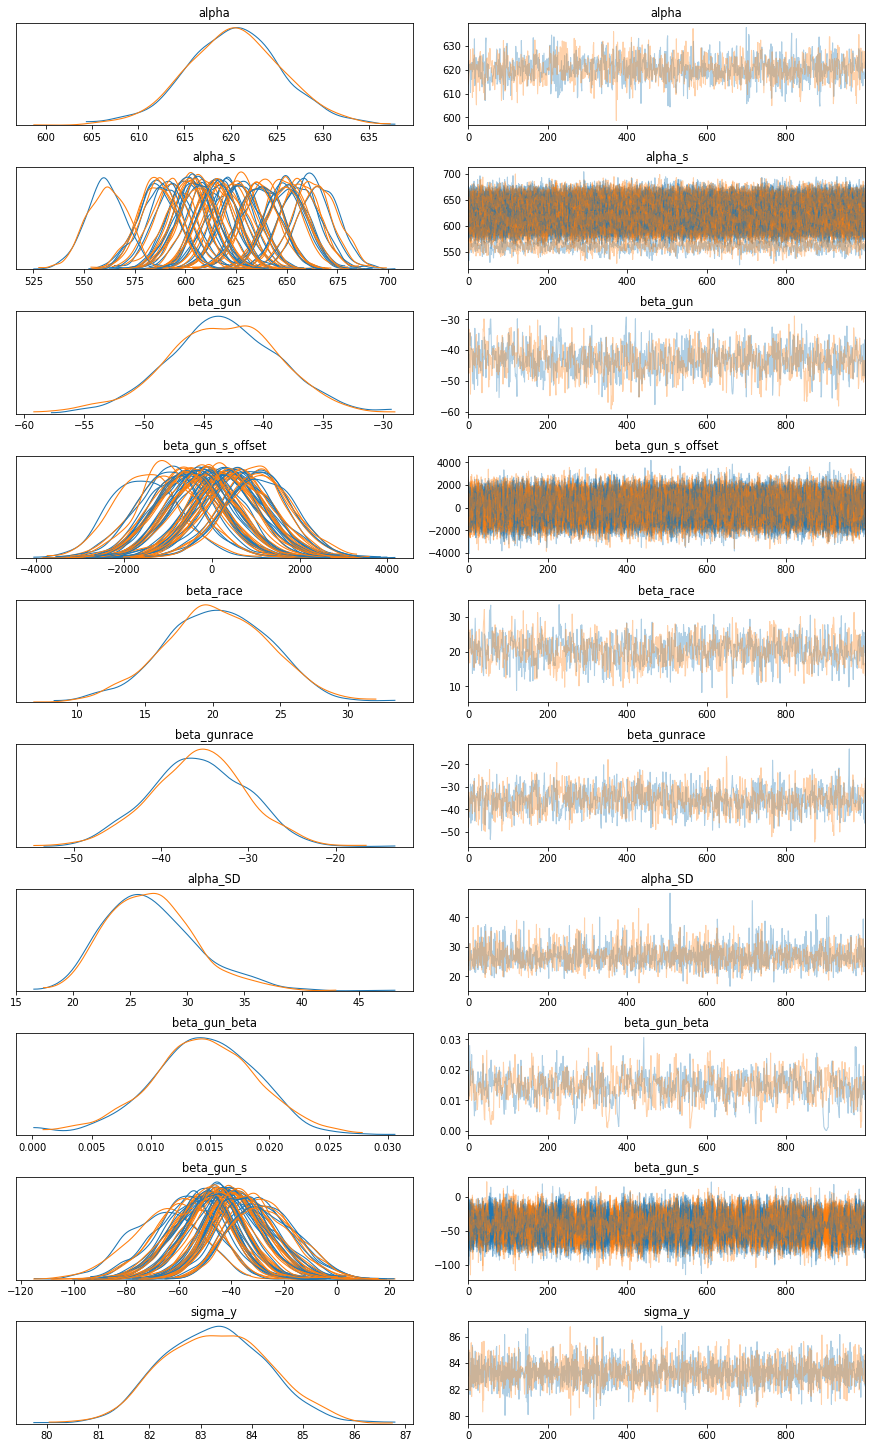

In [122]:
# arviz version 0.6 has a dumb warning that is generated for every plot command (i.e., many)
# It's fixed in 0.7, but I am supressing them here. Not a great practice in general
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    pm.plots.traceplot(my_trace);

/home/xian/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/home/xian/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


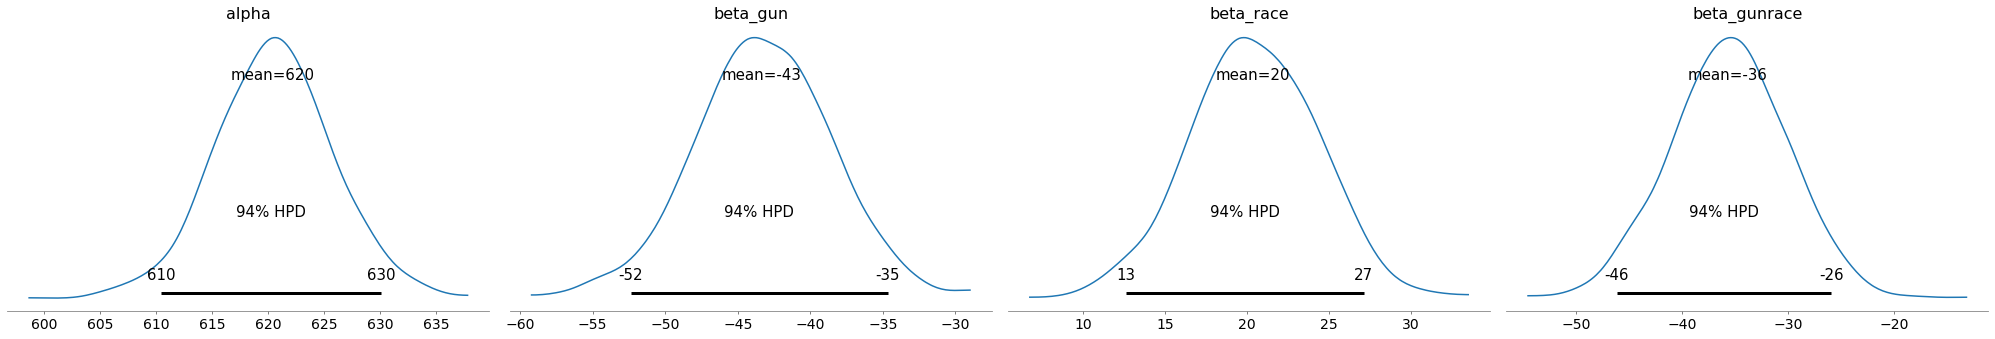

In [123]:
pm.plot_posterior(my_trace, varnames=['alpha', 'beta_gun','beta_race','beta_gunrace']);

In [124]:
(my_trace['beta_race'] < 0).mean()

0.0

## bambi

In [125]:
# do an 'ANOVA' with subject as random effect (per-subject intercepts)
subj_model  = bmb.Model(df)

subj_results = subj_model.fit('rt ~ race * gun',
                             random=['1|subject'],
                             samples=2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rt_sd, 1|subject_offset, 1|subject_sd, race:gun, gun, race, Intercept]
INFO:pymc3:NUTS: [rt_sd, 1|subject_offset, 1|subject_sd, race:gun, gun, race, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 252.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


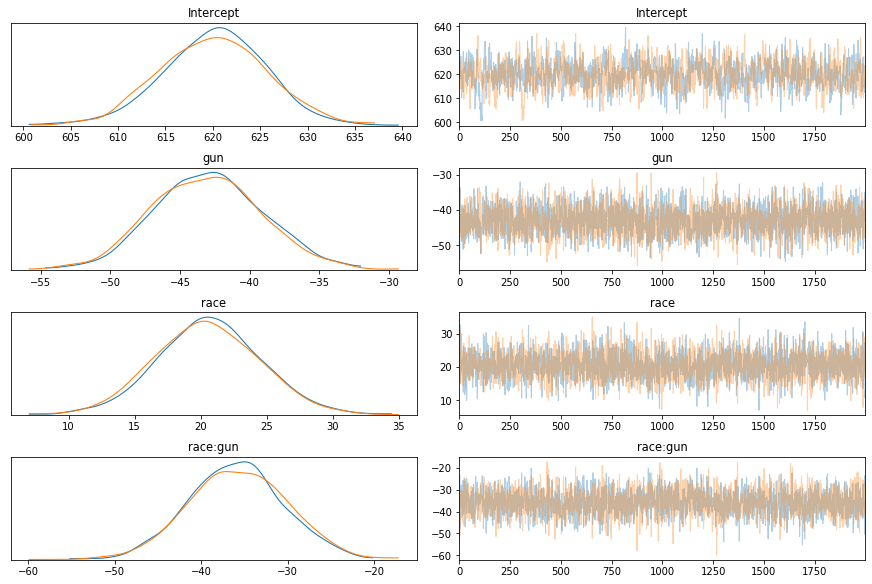

In [126]:
# inspect posteriors & traces

# arviz version 0.6 has a dumb warning that is generated for every plot command (i.e., many)
# It's fixed in 0.7, but I am supressing them here. Not a great practice in general
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    arviz.plot_trace(subj_results, var_names=['Intercept', 'gun', 'race', 'race:gun'], compact=True)
    plt.show()

In [127]:
az.summary(subj_fitted, var_names=['Intercept', 'gun', 'race', 'race:gun'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],619.971,5.336,608.279,628.691,0.584,0.414,84.0,84.0,82.0,160.0,NaN
gun[0],-43.216,4.733,-50.985,-33.899,0.254,0.180,348.0,348.0,350.0,344.0,NaN
race[0],20.584,4.152,12.463,28.391,0.227,0.166,336.0,312.0,336.0,280.0,NaN
race:gun[0],-35.919,5.429,-45.813,-26.178,0.312,0.221,304.0,304.0,297.0,338.0,NaN


- The group-level interaction term (race:gun) has a posterior that is far from zero, suggesting that the interaciton we visualized previously (subjects being relatively faster/slower to shoot armed/unarmed black individual) is probable.

In [128]:
float((subj_results.posterior['race:gun'] < 0).mean())

1.0

So...the posterior probability that the interaction coefficient is less than zero is 0.99.

## Subject and stimulus random effects

In [130]:
subj_and_stim_model  = bmb.Model(df)
subj_and_stim_results = subj_and_stim_model.fit('rt ~ race * gun',
                                                 random=['race * gun | subject', 'gun|stimulus'],
                                                 samples=2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rt_sd, gun|stimulus_offset, gun|stimulus_sd, 1|stimulus_offset, 1|stimulus_sd, race:gun| subject_offset, race:gun| subject_sd, gun| subject_offset, gun| subject_sd, race| subject_offset, race| subject_sd, 1| subject_offset, 1| subject_sd, race:gun, gun, race, Intercept]
INFO:pymc3:NUTS: [rt_sd, gun|stimulus_offset, gun|stimulus_sd, 1|stimulus_offset, 1|stimulus_sd, race:gun| subject_offset, race:gun| subject_sd, gun| subject_offset, gun| subject_sd, race| subject_offset, race| subject_sd, 1| subject_offset, 1| subject_sd, race:gun, gun, race, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [03:58<00:00, 20.96draws/s]


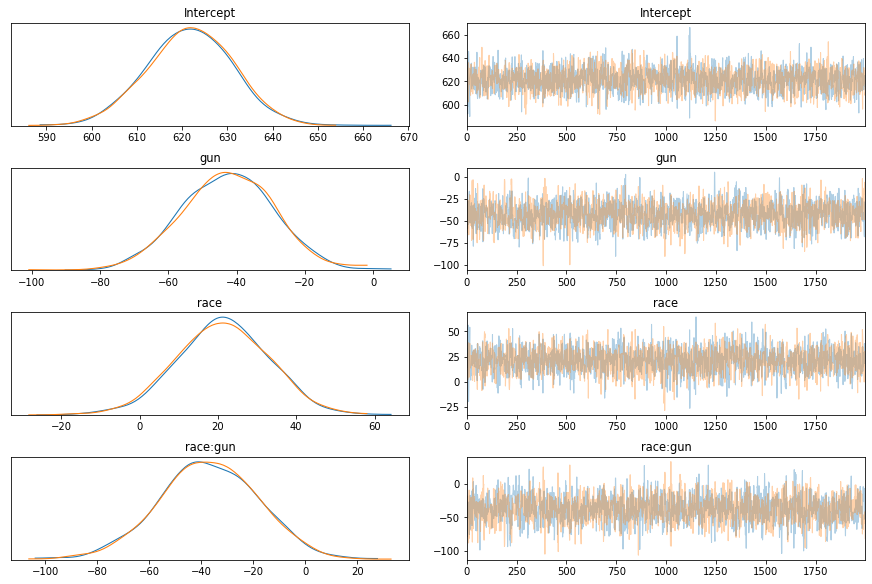

In [131]:
# inspect posteriors & traces

# arviz version 0.6 has a dumb warning that is generated for every plot command (i.e., many)
# It's fixed in 0.7, but I am supressing them here. Not a great practice in general
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    arviz.plot_trace(subj_and_stim_results, var_names=['Intercept', 'gun', 'race', 'race:gun'], compact=True)
    plt.show()

In [132]:
az.summary(subj_fitted, var_names=['Intercept', 'gun', 'race', 'race:gun'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],619.971,5.336,608.279,628.691,0.584,0.414,84.0,84.0,82.0,160.0,NaN
gun[0],-43.216,4.733,-50.985,-33.899,0.254,0.180,348.0,348.0,350.0,344.0,NaN
race[0],20.584,4.152,12.463,28.391,0.227,0.166,336.0,312.0,336.0,280.0,NaN
race:gun[0],-35.919,5.429,-45.813,-26.178,0.312,0.221,304.0,304.0,297.0,338.0,NaN


In [133]:
float((subj_results.posterior['race:gun'] < 0).mean())

1.0

So...now the posterior implies less confidence in the interaction.